In [1]:
import sys
sys.path.append('../')
import numpy as np
from source.reader import read_raw
from source.gridding import NFFT
import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [2]:
file_name = "../data/fisp_phantom.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
idx_chan_sig = slice(num_channels_signal)
idx_chan_ref = slice(num_channels_signal, num_channels_all)
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [3]:
spec_scan = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
spec_prescan = np.fft.fftshift(np.fft.fft(data['noise'], axis=-1), axes=-1)
n_freq_bins = spec_scan.shape[2]
spec_cor = np.zeros([spec_scan.shape[0], num_channels_signal, n_freq_bins], dtype=np.complex64)
coeff_all = np.zeros((num_channels_signal, num_channels_all - num_channels_signal, n_freq_bins), dtype=np.complex64)
for _f in range(n_freq_bins):
    # compute coefficients from prescan
    prescan_sig = spec_prescan[:, idx_chan_sig, _f]
    prescan_ref = spec_prescan[:, idx_chan_ref, _f]
    coeff = np.linalg.lstsq(prescan_ref, prescan_sig, rcond=-1)[0]
    coeff_all[:, :, _f] = coeff
    # apply correction
    scan_sig = spec_scan[:, idx_chan_sig, _f]
    scan_ref = spec_scan[:, idx_chan_ref, _f]
    spec_cor[:, :, _f] = scan_sig - np.dot(scan_ref, coeff)

## Gridding

In [7]:
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:])
img_3d = np.zeros(matrix_size, dtype=np.complex64)
for _f in range(n_freq_bins):
    img_3d[_f, :, :] = encode_op.adjoint(spec_scan[:, 0, _f])


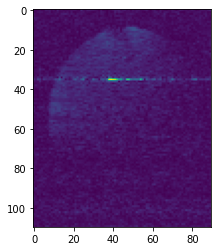

In [8]:
# Plot data
plt.figure()
plt.imshow(np.abs(img_3d[:, :, 16]))
plt.show()